#Libraries Import

In [ ]:
import numpy as np
import pandas as pd
from itertools import cycle

import xgboost as xgb
from xgboost import plot_importance
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential, Input, callbacks
from keras.utils.np_utils import to_categorical as cat

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import time

import warnings
warnings.filterwarnings('ignore')

#Load Data

In [ ]:
#Read the data file
data = pd.read_csv('all_data.csv')

#Get speech data only
data = data[data['Vocality']==1]

#EDA

##First 5 entries

In [ ]:
#Print first 5 entries
data.head()

,Filename,Vocality,Emotion,Intensity,Statement,Repetition,Speaker,Sex,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,...,slopeUV0.500_sma3nz_amean,slopeUV500.1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,03-01-01-01-01-01-01,1,1,1,1,1,1,m,24.263884,0.104171,...,0.058064,0.011220,0.005713,2.127660,0.925926,0.336667,0.226912,0.540000,0.480260,-47.939644
1,03-01-01-01-01-02-01,1,1,1,1,2,1,m,25.167889,0.103561,...,0.050419,0.012741,0.005434,2.409639,1.223242,0.257500,0.089826,0.535000,0.485206,-47.342330
2,03-01-01-01-02-01-01,1,1,1,2,1,1,m,24.186604,0.103495,...,0.055127,0.014029,0.007729,2.153846,0.630915,0.545000,0.175000,0.676667,0.414836,-45.849762
3,03-01-01-01-02-02-01,1,1,1,2,2,1,m,24.268760,0.096042,...,0.056815,0.012169,0.008324,2.222222,0.977199,0.333333,0.267374,0.500000,0.445702,-46.193146
4,03-01-02-01-01-01-01,1,2,1,1,1,1,m,24.898132,0.117897,...,0.062112,0.010664,0.007934,2.840909,1.440922,0.182000,0.116172,0.408333,0.441717,-50.563885


##Last 5 entries

In [ ]:
#Print last 5 entries
data.tail()

,Filename,Vocality,Emotion,Intensity,Statement,Repetition,Speaker,Sex,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,...,slopeUV0.500_sma3nz_amean,slopeUV500.1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
1435,03-01-08-01-02-02-24,1,8,1,2,2,24,f,44.332615,0.118625,...,0.118151,0.008159,0.009002,2.064897,0.898204,0.420000,0.351852,0.502500,0.467834,-37.611150
1436,03-01-08-02-01-01-24,1,8,2,1,1,24,f,43.539474,0.138447,...,0.086890,0.008436,0.032158,2.040816,1.550388,0.248333,0.151263,0.321429,0.430429,-33.897774
1437,03-01-08-02-01-02-24,1,8,2,1,2,24,f,45.137974,0.160381,...,0.101797,0.006154,0.036091,2.020202,1.278773,0.284000,0.136029,0.396667,0.468496,-35.436405
1438,03-01-08-02-02-01-24,1,8,2,2,1,24,f,43.194508,0.098176,...,0.068428,0.005634,0.067544,1.912568,1.385042,0.272000,0.211603,0.356667,0.347499,-32.892555
1439,03-01-08-02-02-02-24,1,8,2,2,2,24,f,44.371800,0.112749,...,0.057204,0.003921,0.045650,2.486188,1.680672,0.213333,0.178668,0.358333,0.419659,-33.374500


##Rows and Columns

In [ ]:
#Print shape (rows, columns)
print("Shape of the data: ", data.shape)

Shape of the data:  (1440, 96)


##Statistical Features

In [ ]:
#Print statistical info
data.describe()

,Vocality,Emotion,Intensity,Statement,Repetition,Speaker,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,...,slopeUV0.500_sma3nz_amean,slopeUV500.1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
count,1440.0,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,1.0,4.733333,1.466667,1.500000,1.500000,12.500000,34.143513,0.121219,31.480246,34.240384,...,0.044736,0.008817,0.025677,2.270181,1.233549,0.328097,0.194752,0.474964,0.433307,-39.678309
std,0.0,2.175356,0.499061,0.500174,0.500174,6.924591,6.837588,0.057822,6.916703,7.117360,...,0.046939,0.003417,0.032267,0.372850,0.400480,0.160468,0.117533,0.139539,0.065784,9.072861
min,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,19.132915,0.011401,16.229328,19.398083,...,-0.066052,-0.004034,0.002665,1.123595,0.262467,0.030000,0.000000,0.113636,0.005000,-63.689840
25%,1.0,3.000000,1.000000,1.000000,1.000000,6.750000,28.351341,0.081820,25.388320,28.397562,...,0.003752,0.006666,0.009683,2.005731,0.925926,0.225929,0.112734,0.378333,0.413642,-45.931043
50%,1.0,5.000000,1.000000,1.500000,1.500000,12.500000,34.819469,0.111351,32.189760,34.921245,...,0.049786,0.008799,0.015392,2.247191,1.186944,0.300000,0.165037,0.448000,0.437964,-40.057233
75%,1.0,7.000000,2.000000,2.000000,2.000000,18.250000,38.482380,0.148261,35.698548,38.877650,...,0.085659,0.011192,0.027693,2.506266,1.483680,0.400000,0.257731,0.535000,0.459212,-33.840566
max,1.0,8.000000,2.000000,2.000000,2.000000,24.000000,56.256943,0.454349,55.727802,56.963930,...,0.128442,0.019098,0.332437,3.651686,3.542234,1.670000,0.925000,1.820000,0.944893,-16.341972


##Unique entries in each column

In [ ]:
#Number of unique entries in each column
data.nunique()

Filename                        1440
Vocality                           1
Emotion                            8
Intensity                          2
Statement                          2
                                ... 
MeanVoicedSegmentLengthSec       496
StddevVoicedSegmentLengthSec    1326
MeanUnvoicedSegmentLength        408
StddevUnvoicedSegmentLength     1360
equivalentSoundLevel_dBp        1439
Length: 96, dtype: int64

##Checking missing values

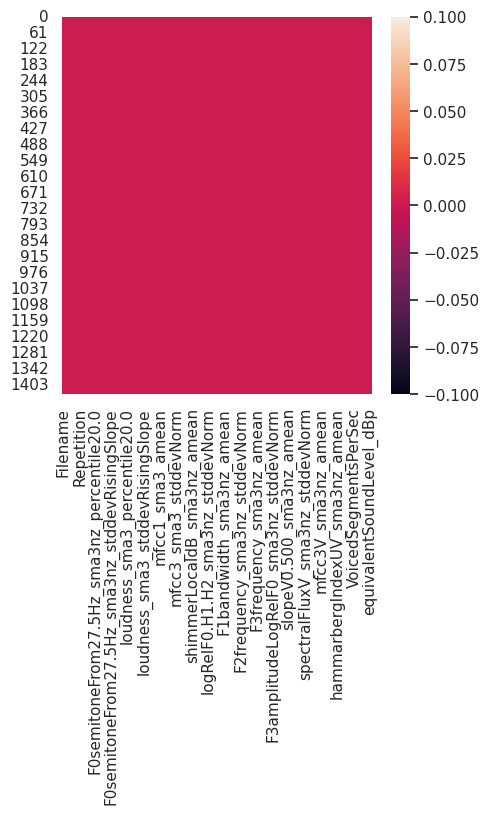

In [ ]:
#Creating a heat map to see which columns have missing points
sns.set_theme(style='whitegrid', palette='Dark2')
plt.figure(figsize=(5,5),dpi=100)
sns.heatmap(data.isnull());
plt.savefig('Vector.svg')

##Emotion distribution

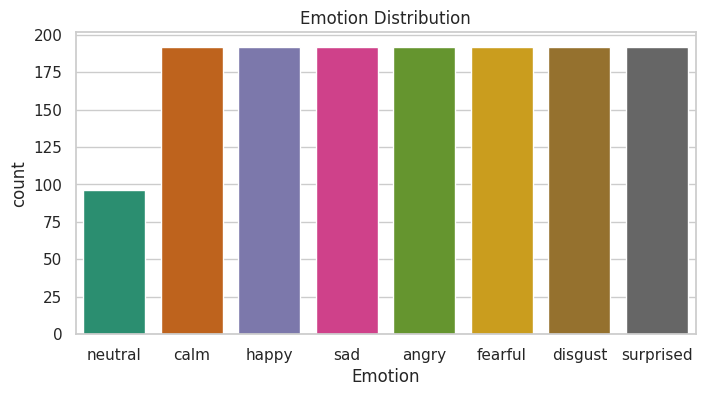

In [ ]:
#Emotion labels
LABELS = {1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 :'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}

#Emotion Distribution
plt.figure(figsize=(8,4),dpi=100)
sns.countplot(data['Emotion'].map(LABELS));
plt.title("Emotion Distribution");

##Emotion Count

In [ ]:
df_temp = data.copy()

df_temp['Emotion'] = df_temp['Emotion'].map(LABELS)

df_temp.groupby(['Emotion'])['Emotion'].count()

Emotion
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: Emotion, dtype: int64

##Feature correlations

In [ ]:
#Correlation between features 
fig, ax = plt.subplots(figsize=(100,100), dpi=100)

#Create a heatmap using seaborn
sns.heatmap(data.drop(columns=['Filename',
                               'Vocality',
                               'Intensity',
                               'Statement',
                               'Repetition',
                               'Speaker',
                               'Sex']).corr(), annot=True, cmap='viridis');
plt.title('Features correlation matrix')

##Feature's probability distribution

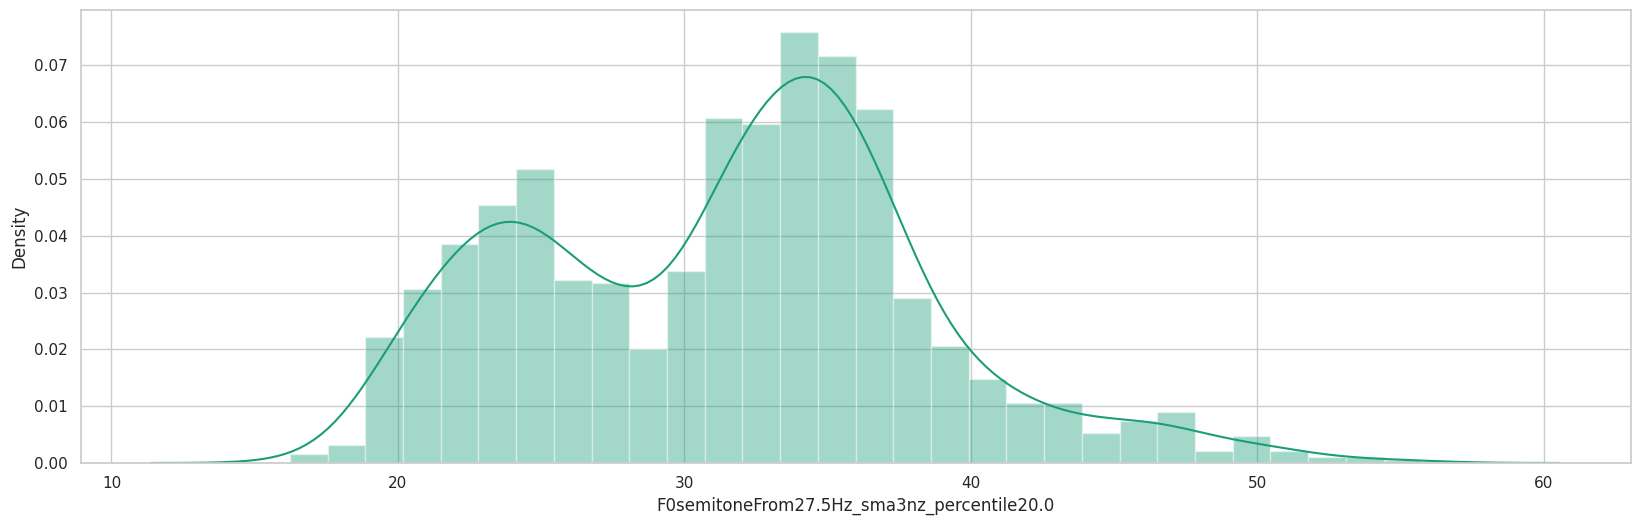

In [ ]:
#Pick random feature and plot
plt.figure(figsize=(20,6),dpi=100)
sns.distplot(data[np.random.choice(feature_cols)], bins=30);

##Scatter plot b/w features

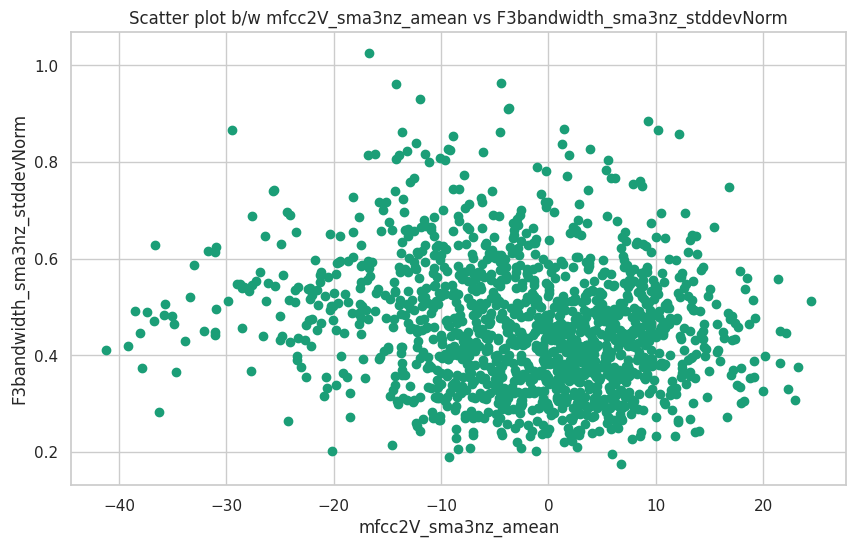

In [ ]:
#Pick two features at random
f1 = np.random.choice(feature_cols)
f2 = np.random.choice(feature_cols)

#Plot f1 and f2 using scatter
plt.figure(figsize=(10,6),dpi=100)
plt.scatter(data[f1], data[f2], marker='o');
plt.xlabel(f1)
plt.ylabel(f2)
plt.title("Scatter plot b/w "+f1+" vs "+f2);

#Data Preprocessing

##Delete unnecessary columns

In [ ]:
#Emotion labels
LABELS = {1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 :'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}

#Unnecessary columns
cols_to_drop = ['Filename', 'Vocality', 'Intensity', 'Statement', 'Repetition', 'Speaker', 'Sex']

#Drop values columns
data_ml = data.drop(columns = cols_to_drop)

##Separate feature and labels

In [ ]:
#Create X and Y
Y = data_ml['Emotion']
X = data_ml.drop(columns=['Emotion'])

##Scale data

In [ ]:
#Standard scaler
enc = StandardScaler()

#Scale the data
X_scaled = enc.fit_transform(X)

##Split data

In [ ]:
#Create train and test splits
xtrain_1, xtest_1, ytrain_1, ytest_1 = train_test_split(X_scaled, Y, test_size=0.15, stratify = Y, random_state=26)

#ROC and Confusion Matrix

In [ ]:
def ROC_AUC(score):
  n_classes = 8
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(label_binarize(ytest_1, classes=[1, 2, 3, 4, 5, 6, 7, 8])[:, i], score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(ytest_1, classes=[1, 2, 3, 4, 5, 6, 7, 8]).ravel(), score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  lw = 2
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  sns.set_theme(style='whitegrid', palette='Dark2')
  plt.figure(figsize=(8,6), dpi=100)

  colors = cycle(["aqua", "darkorange", "cornflowerblue", "purple", "forestgreen", "saddlebrown","gold", "crimson", "steelblue", "gray", "olive"])
  lab = [l for l in LABELS.values()]
  for i, color in zip(range(n_classes), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label=lab[i],
      )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.title("Receiver Operating Characteristic")
  plt.show()
  print("Average Area Under Curve is: ", round(roc_auc['micro'], 2))


#This function is used for plotting the confusion matrix
def plot_confusion_matrix(ytrue, ypred):
    matrix = metrics.confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(8, 8),dpi=100)
    sns.heatmap(matrix,
                cmap='Blues',
                linecolor='white',
                linewidths=1,
                xticklabels=list(LABELS.values()),
                yticklabels=list(LABELS.values()),
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')
    plt.show()

#SVM

###Grid Search

In [ ]:
svm_hyper_param = {'kernel' : ['linear', 'poly', 'rbf'],
               'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'gamma' : ['scale', 'auto'],
               'class_weight' : ['balanced', None]}

svm_model_1 = SVC(probability=True)

svm_grid_1 = GridSearchCV(svm_model_1,
                        svm_hyper_param,
                        verbose = 1,
                        n_jobs = -1,
                        cv = 5,
                        scoring = 'f1_micro')

svm_grid_1.fit(xtrain_1, ytrain_1)

svm_best_param_1 = svm_grid_1.best_params_

print(f"Best Parameters     : {svm_best_param_1}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters     : {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}


###Best model

In [ ]:
best_model_svm_1 = OneVsRestClassifier(
    SVC(kernel='rbf',
        gamma='auto',
        class_weight=None,
        C = 10,
        probability=True)
)

best_model_svm_1.fit(xtrain_1, label_binarize(ytrain_1, classes=[1, 2, 3, 4, 5, 6, 7, 8]))

svm_inf = []

for i in range(100):
  t = time.perf_counter()

  svm_pred_1_score = best_model_svm_1.decision_function(xtest_1)

  svm_inf.append(time.perf_counter()-t)

print("SVM Inference time is: ", round(np.mean(svm_inf), 2), " Seconds")

SVM Inference time is:  0.07  Seconds


###ROC CURVE

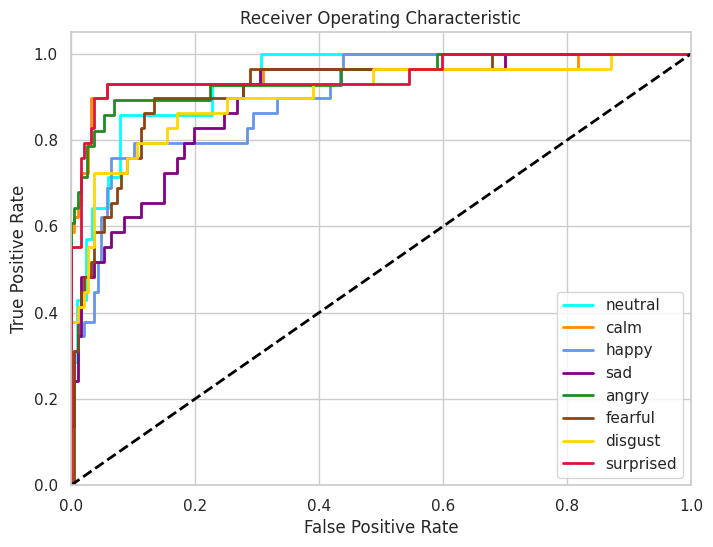

Average Area Under Curve is:  0.93


In [ ]:
ROC_AUC(svm_pred_1_score)

###Classification Report

In [ ]:
# #Classification report
print(metrics.classification_report(ytest_1,
                                    np.argmax(svm_pred_1_score,axis = 1)+1,
                                    target_names=[l for l in list(LABELS.values())]))

              precision    recall  f1-score   support

     neutral       0.59      0.71      0.65        14
        calm       0.77      0.83      0.80        29
       happy       0.62      0.62      0.62        29
         sad       0.70      0.55      0.62        29
       angry       0.92      0.86      0.89        28
     fearful       0.67      0.76      0.71        29
     disgust       0.67      0.69      0.68        29
   surprised       0.81      0.76      0.79        29

    accuracy                           0.72       216
   macro avg       0.72      0.72      0.72       216
weighted avg       0.73      0.72      0.72       216



###Accuracy Score

In [ ]:
print(metrics.accuracy_score(ytest_1, np.argmax(svm_pred_1_score,axis = 1)+1)*100)

72.22222222222221


###Confusion Matrix

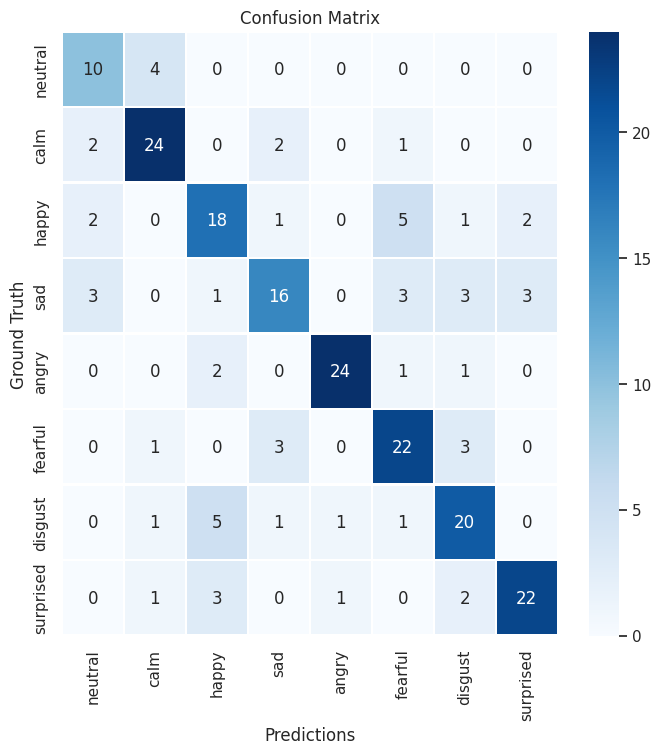

In [ ]:
plot_confusion_matrix(ytest_1, np.argmax(svm_pred_1_score,axis = 1)+1)

#XGBoost

###Grid Search

In [ ]:
xgb_hyper_param = {'max_depth' : range(10,16),
              'n_estimators' : [200, 250, 300],
              'lamda' : [0.1, 0.3, 0.5],
              'colsample_bytree' : [0.1, 0.3, 0.5],
              'learning_rate' : [0.001, 0.01, 0.1]}

xgb_model_1 = xgb.XGBClassifier(objective="multi:softprob", random_state = 1, nthread = -1, n_jobs = -1)

xgb_grid_1 = GridSearchCV(xgb_model_1,
                          xgb_hyper_param,
                          verbose = 1,
                          n_jobs = -1,
                          cv = 5,
                          scoring = 'f1_micro')

xgb_grid_1.fit(xtrain_1, ytrain_1-1)

xgb_best_param_1 = xgb_grid_1.best_params_

print(f"Best Parameters     : {xgb_best_param_1}")

###Best Model

In [ ]:
#XGBoost Model
best_model_xgb_1 = xgb.XGBClassifier(n_estimators= 250,
                  learning_rate= 0.01,
                  objective="multi:softprob",
                  max_depth=14,
                  lamda=0.5,
                  colsample_bytree=0.3,
                  probability=True)

#Model training
best_model_xgb_1.fit(xtrain_1, ytrain_1-1,
                     eval_metric="mlogloss",
                     eval_set=[(xtrain_1, ytrain_1-1), (xtest_1, ytest_1-1)],
                     verbose=False)

#Predict probability
xgb_pred_1_score = best_model_xgb_1.predict_proba(xtest_1)


xgb_inf = []

for i in range(100):
  t = time.perf_counter()

  #Model prediction
  xgb_pred_1  = best_model_xgb_1.predict(xtest_1) + 1

  xgb_inf.append(time.perf_counter()-t)

print("XGB Inference time is: ", round(np.mean(xgb_inf), 2), " Seconds")

XGB Inference time is:  0.07  Seconds


###Learning curve

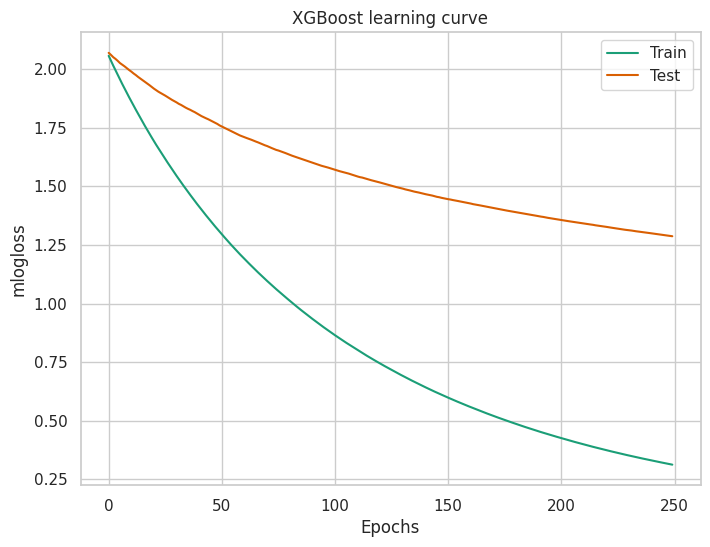

In [ ]:
results = best_model_xgb_1.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('mlogloss')
plt.title('XGBoost learning curve')
plt.show()


###ROC CURVE

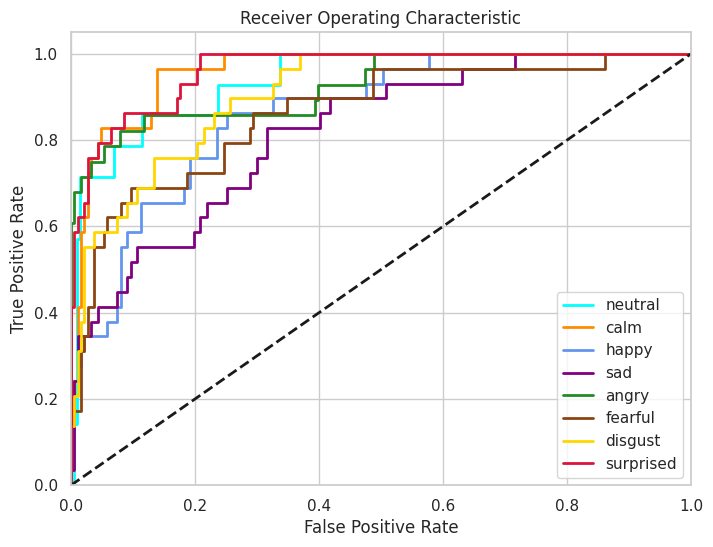

Average Area Under Curve is:  0.91


In [ ]:
ROC_AUC(xgb_pred_1_score)

###Classification Report

In [ ]:
#Classification report
print(metrics.classification_report(ytest_1, xgb_pred_1, target_names=[l for l in list(LABELS.values())]))

              precision    recall  f1-score   support

     neutral       0.50      0.29      0.36        14
        calm       0.67      0.90      0.76        29
       happy       0.47      0.48      0.47        29
         sad       0.67      0.34      0.45        29
       angry       0.76      0.79      0.77        28
     fearful       0.53      0.55      0.54        29
     disgust       0.61      0.69      0.65        29
   surprised       0.72      0.79      0.75        29

    accuracy                           0.62       216
   macro avg       0.61      0.60      0.60       216
weighted avg       0.62      0.62      0.61       216



###Accuracy Score

In [ ]:
print(metrics.accuracy_score(ytest_1, xgb_pred_1)*100)

62.5


###Confusion Matrix

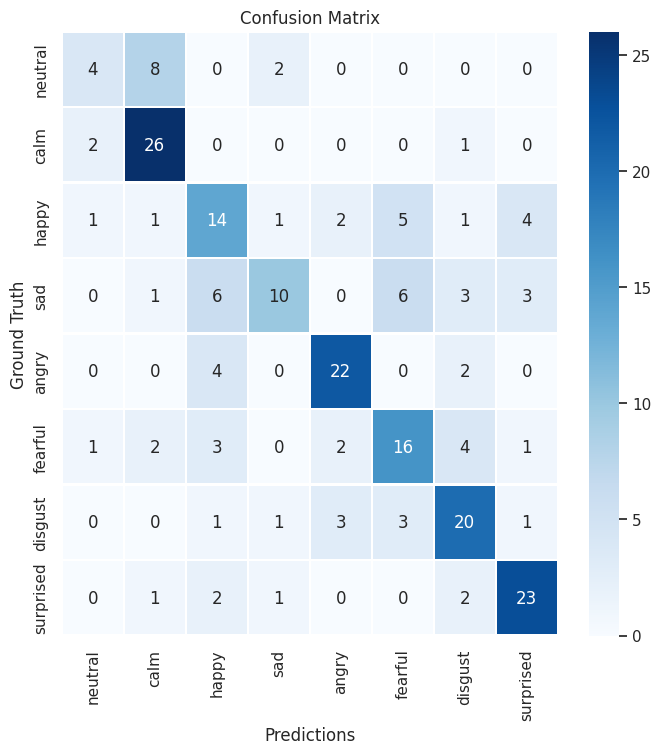

In [ ]:
plot_confusion_matrix(ytest_1, xgb_pred_1)

###Feature Importance

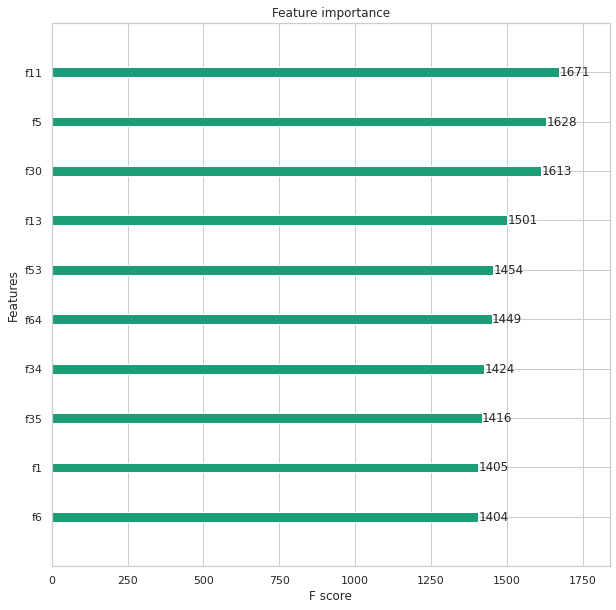

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# plot feature importance
plot_importance(best_model_xgb_1,ax=ax, max_num_features=10)

#ANN

###Model Design

In [ ]:
#Output classes
n_outputs = 8

#Create DNN model
def dnn_model(xtrain):

  model = Sequential()

  #First hidden layer
  model.add(Dense(64, activation='relu', input_shape = (xtrain.shape[1],)))
  #Second Hidden layer
  model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02)))
  #Dropout layer
  model.add(Dropout(0.2))
  #Third hidden layer
  model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02)))
  #Output layer
  model.add(Dense(n_outputs, activation='softmax'))

  #Compile the model
  model.compile(loss='categorical_crossentropy',
                              metrics=['acc'], 
                              optimizer= 'adam')
  return model

###Model Training

In [ ]:
#Create model
model_1 = dnn_model(xtrain_1)

#Train model
model1_hist = model_1.fit(xtrain_1.astype(float), cat(ytrain_1-1, n_outputs).astype(float),
                          validation_data=(xtest_1.astype(float),cat(ytest_1-1, n_outputs).astype(float)),
                          batch_size=16, 
                          verbose=1, 
                          epochs = 200)

ann_inf = []

for i in range(100):
  t = time.perf_counter()

  dnn_pred_1_score = model_1.predict(xtest_1, verbose=0)

  ann_inf.append(time.perf_counter()-t)

print("ANN Inference time is: ", round(np.mean(ann_inf), 2), " Seconds")

Epoch 1/200
77/77 [==============================] - 1s 6ms/step - loss: 13.5664 - acc: 0.1732 - val_loss: 9.6231 - val_acc: 0.2407
Epoch 2/200
77/77 [==============================] - 0s 3ms/step - loss: 6.9706 - acc: 0.2541 - val_loss: 4.7146 - val_acc: 0.3148
Epoch 3/200
77/77 [==============================] - 0s 4ms/step - loss: 3.4997 - acc: 0.2827 - val_loss: 2.5888 - val_acc: 0.3056
Epoch 4/200
77/77 [==============================] - 0s 3ms/step - loss: 2.2983 - acc: 0.2598 - val_loss: 2.0957 - val_acc: 0.2824
Epoch 5/200
77/77 [==============================] - 0s 4ms/step - loss: 2.0359 - acc: 0.2639 - val_loss: 1.9775 - val_acc: 0.2731
Epoch 6/200
77/77 [==============================] - 0s 3ms/step - loss: 1.9453 - acc: 0.2533 - val_loss: 1.9200 - val_acc: 0.3194
Epoch 7/200
77/77 [==============================] - 0s 4ms/step - loss: 1.9119 - acc: 0.2827 - val_loss: 1.8949 - val_acc: 0.3287
Epoch 8/200
77/77 [==============================] - 0s 4ms/step - loss: 1.8921 - 

###Loss and Accuracy Plot

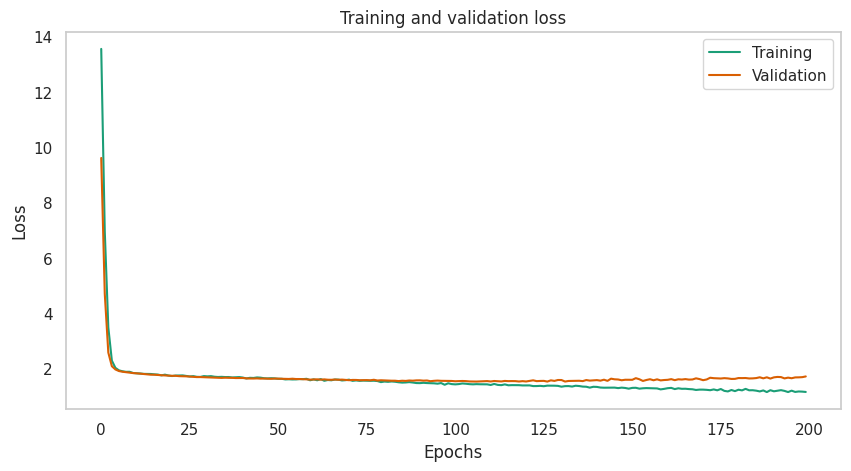

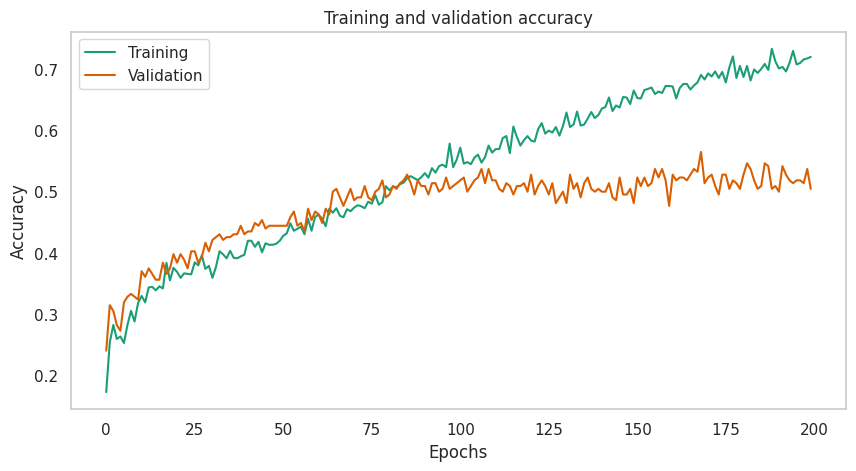

In [ ]:
epochs = 200

plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),model1_hist.history['loss']);
plt.plot(range(epochs),model1_hist.history['val_loss']);
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.grid()

plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(epochs),model1_hist.history['acc']);
plt.plot(range(epochs),model1_hist.history['val_acc']);
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.grid()

###ROC CURVE

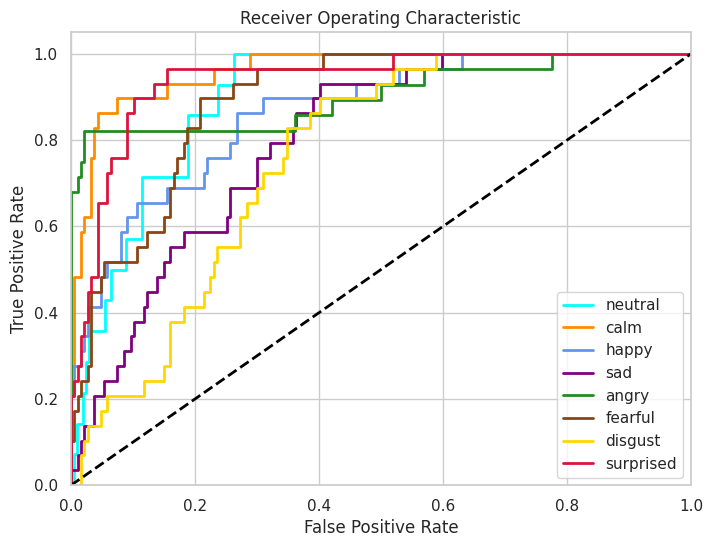

Average Area Under Curve is:  0.88


In [ ]:
ROC_AUC(dnn_pred_1_score)

###Classification Report

In [ ]:
#Model prediction
dnn_pred_1 = np.argmax(dnn_pred_1_score,axis=1)+1

#Classification report
print(metrics.classification_report(ytest_1, dnn_pred_1, target_names=[l for l in list(LABELS.values())]))

              precision    recall  f1-score   support

     neutral       0.43      0.21      0.29        14
        calm       0.81      0.59      0.68        29
       happy       0.54      0.45      0.49        29
         sad       0.30      0.45      0.36        29
       angry       0.61      0.82      0.70        28
     fearful       0.50      0.59      0.54        29
     disgust       0.25      0.21      0.23        29
   surprised       0.71      0.59      0.64        29

    accuracy                           0.50       216
   macro avg       0.52      0.49      0.49       216
weighted avg       0.52      0.50      0.50       216



###Confusion Matrix

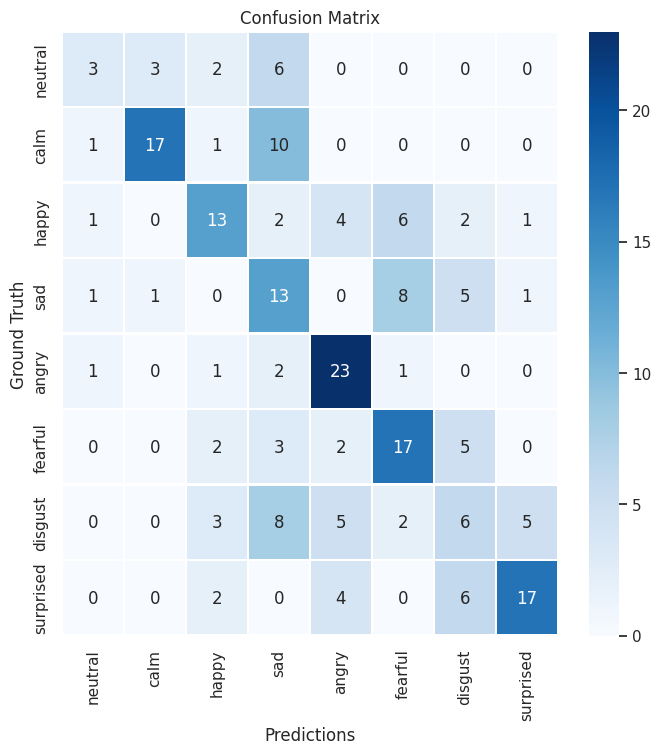

In [ ]:
plot_confusion_matrix(ytest_1, dnn_pred_1)

#Synthetic Data Generation using CTGAN

###Install and Import CTGAN

In [ ]:
%%capture
!pip install sdv
from sdv.tabular import CTGAN

###Create copy of dataset

In [ ]:
#Emotion labels
LABELS = {1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 :'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}

#Create a copy of original data
data_new = data.copy()

#Unnecessary columns
cols_to_drop = ['Filename', 'Vocality', 'Intensity', 'Statement', 'Repetition', 'Speaker', 'Sex']

#Drop values columns
data_new = data_new.drop(columns = cols_to_drop)

###Perform CTGAN

In [ ]:
# Train CTGAN Model
ctg_model = CTGAN()

ctg_model.fit(data_new)

# Save trained model
ctg_model.save("sdv-ctgan.pkl")

# Load pre-train model
ctg_model = CTGAN.load('sdv-ctgan.pkl')

# Create synthetic data
synthetic_data = ctg_model.sample(1000)

# Save synthetic data to csv
synthetic_data.to_csv('synthetic_1k.csv')

###Create train test split

In [ ]:
data_train, data_test = train_test_split(data_new, test_size=0.15, random_state=26)

Y_test = data_test['Emotion']
X_test = data_test.drop(columns=['Emotion'])

###Combine dataset

In [ ]:
synthetic_data = pd.read_csv('synthetic_1k.csv')
comb_data = pd.concat([data_train, synthetic_data], axis=0)

Y_com = comb_data['Emotion']
X_com = comb_data.drop(columns=['Emotion', 'Unnamed: 0'])

###Scale dataset

In [ ]:
#Standard scaler
enc = StandardScaler()

enc.fit(X_com)

X_res_scaled = enc.transform(X_com)

X_test_scaled = enc.transform(X_test)

#SVM

###Grid Search

In [ ]:
svm_hyper_param = {'kernel' : ['linear', 'poly', 'rbf'],
               'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'gamma' : ['scale', 'auto'],
               'class_weight' : ['balanced', None]}

svm_model_5 = SVC(probability=True)

svm_grid_5 = RandomizedSearchCV(svm_model_5,
                        svm_hyper_param,
                        verbose = 1,
                        n_jobs = -1,
                        cv = 5,
                        scoring = 'f1_micro',
                        n_iter=10)

svm_grid_5.fit(X_res_scaled, Y_com)

svm_best_param_5 = svm_grid_5.best_params_

print(f"Best Parameters     : {svm_best_param_5}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


###Best Model

In [ ]:
#Create SVM Model
best_model_svm_5 = SVC(kernel='poly',
                gamma='auto',
                class_weight=None,
                C = 1000)

#Model traning
best_model_svm_5.fit(X_res_scaled, Y_com)

#Model prediction
svm_pred_5 = best_model_svm_5.predict(X_test_scaled)

#Classification report
print(metrics.classification_report(Y_test, svm_pred_5, target_names=[l for l in list(LABELS.values())]))

              precision    recall  f1-score   support

     neutral       0.56      0.60      0.58        15
        calm       0.79      0.79      0.79        33
       happy       0.53      0.64      0.58        33
         sad       0.52      0.46      0.49        24
       angry       0.82      0.75      0.78        24
     fearful       0.72      0.54      0.62        24
     disgust       0.58      0.81      0.68        26
   surprised       0.80      0.65      0.72        37

    accuracy                           0.66       216
   macro avg       0.67      0.65      0.65       216
weighted avg       0.68      0.66      0.66       216



#XGBoost

###Grid Search

In [ ]:
xgb_param_values = [i/10 for i in range(1, 3, 1)]

xgb_hyper_param = {'max_depth' : range(10,18),
              'gamma' : xgb_param_values,
              'colsample_bytree' : xgb_param_values,
              'lambda' : xgb_param_values,
              'n_estimators' : [100, 150, 200],
              'min_child_weight' : xgb_param_values}

xgb_model_5 = xgb.XGBClassifier(objective="multi:softprob", random_state = 1, nthread = -1, n_jobs = -1)

xgb_grid_5 = RandomizedSearchCV(xgb_model_5,
                          xgb_hyper_param,
                          verbose = 1,
                          n_jobs = -1,
                          cv = 5,
                          scoring = 'f1_micro',
                          n_iter=10)

xgb_grid_5.fit(X_res_scaled, Y_com-1)

xgb_best_param_5 = xgb_grid_5.best_params_

print(f"Best Parameters     : {xgb_best_param_5}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters     : {'n_estimators': 200, 'min_child_weight': 0.1, 'max_depth': 10, 'lambda': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.2}


###Best Model

In [ ]:
#XGBoost Model
best_model_xgb_5 = xgb.XGBClassifier(n_estimators= 400,
                  learning_rate= 0.15,
                  objective="multi:softprob",
                  max_depth=14,
                  lamda=0.5,
                  probability=True)

#Model training
best_model_xgb_5.fit(X_res_scaled, Y_com-1)

#Model prediction
xgb_pred_5  = best_model_xgb_5.predict(X_test_scaled)+1

#Classification report
print(metrics.classification_report(Y_test, xgb_pred_5, target_names=[l for l in list(LABELS.values())]))

              precision    recall  f1-score   support

     neutral       0.64      0.47      0.54        15
        calm       0.74      0.88      0.81        33
       happy       0.67      0.55      0.60        33
         sad       0.50      0.50      0.50        24
       angry       0.79      0.79      0.79        24
     fearful       0.64      0.67      0.65        24
     disgust       0.62      0.69      0.65        26
   surprised       0.81      0.81      0.81        37

    accuracy                           0.69       216
   macro avg       0.68      0.67      0.67       216
weighted avg       0.69      0.69      0.69       216



In [ ]:
print(metrics.accuracy_score(Y_test, xgb_pred_5)*100)

68.98148148148148


#ANN

In [ ]:
#Output classes
n_outputs = 8

#Create DNN model
def dnn_model(xtrain):
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape = (xtrain.shape[1],)))
  model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02)))
  model.add(Dropout(0.3))
  # model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02)))
  model.add(Dense(n_outputs, activation='softmax'))

  #Compile the model
  model.compile(loss='categorical_crossentropy',
                              metrics=['acc'], 
                              optimizer= 'adam')
  return model

In [ ]:
#Create model
model_5 = dnn_model(X_res_scaled)

#Train model
model_5.fit(X_res_scaled.astype(float), cat(Y_com-1, n_outputs).astype(float),
          validation_data = (X_test_scaled.astype(float), cat(Y_test-1, n_outputs).astype(float)),
            batch_size=16, 
            verbose=0, 
            epochs = 100)

#Model prediction
dnn_pred_5 = np.argmax(model_5.predict(X_test_scaled),axis=1)+1

#Classification report
print(metrics.classification_report(Y_test, dnn_pred_5, target_names=[l for l in list(LABELS.values())]))

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     neutral       0.50      0.60      0.55        15
        calm       0.75      0.73      0.74        33
       happy       0.44      0.21      0.29        33
         sad       0.52      0.58      0.55        24
       angry       0.59      0.83      0.69        24
     fearful       0.53      0.38      0.44        24
     disgust       0.64      0.62      0.63        26
   surprised       0.66      0.84      0.74        37

    accuracy                           0.60       216
   macro avg       0.58      0.60      0.58       216
weighted avg       0.59      0.60      0.58       216



#Overall Comparison

##Accuracy

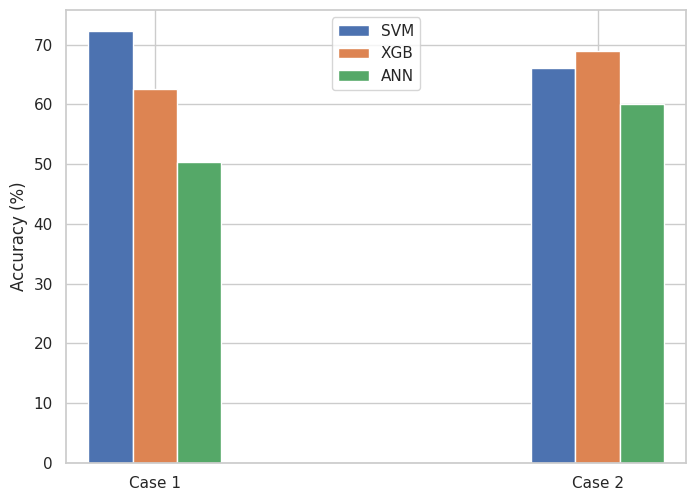

In [ ]:
#SVM Accuracies
svm_1 = 0.722; svm_5 = 0.66

#XGB Accuracies
xgb_1 = 0.625; xgb_5 = 0.689

#ANN Accuracies
ann_1 = 0.504; ann_5 = 0.60


# Plot Accuracies
x = np.arange(2)
c1 = [svm_1*100, svm_5*100]
c2 = [xgb_1*100, xgb_5*100]
c3 = [ann_1*100, ann_5*100]
width = 0.1

sns.set_theme(style='whitegrid', palette='deep')
plt.figure(figsize=(8,6), dpi=100)
  
# plot data in grouped manner of bar type
plt.bar(x-0.1, c1, width, color='C0')
plt.bar(x, c2, width, color='C1')
plt.bar(x+0.1, c3, width, color='C2')
plt.xticks(x, ['Case 1', 'Case 2'])
# plt.xlabel("Position")
plt.ylabel("Accuracy (%)")
plt.legend(["SVM", "XGB", "ANN"],loc='upper center')
plt.xlim([-0.2, 1.2])
plt.show()

##Time Comparison

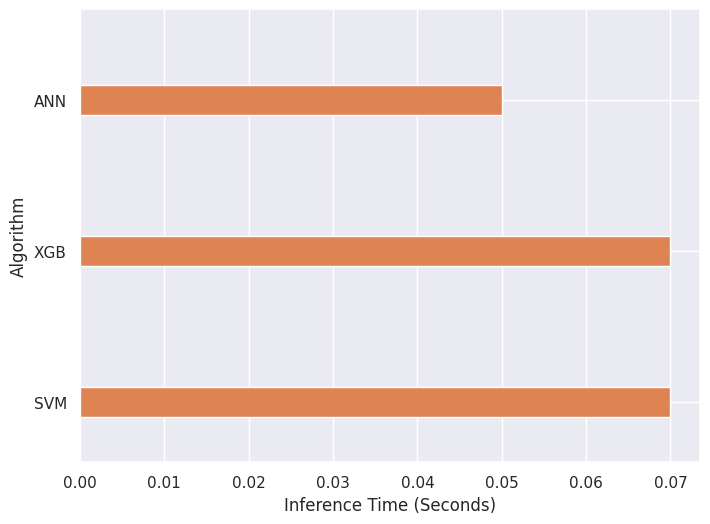

In [ ]:
svm_time = 0.07
xgb_time = 0.07
ann_time = 0.05

# create data
x = np.arange(3)
y1 = [svm_time, xgb_time, ann_time]

width = 0.2

sns.set_theme()
plt.figure(figsize=(8,6), dpi=100)
  
# plot data in grouped manner of bar type
plt.barh(x, y1, width, color='C1')
plt.xlabel("Inference Time (Seconds)")
plt.ylabel("Algorithm")
plt.yticks(x, ['SVM', 'XGB', 'ANN'])
plt.ylim([-0.4, 2.6])
plt.show()